## Load in the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config

from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

import statsmodels.tsa.api as tsa

In [2]:

url ="https://docs.google.com/spreadsheets/d/e/2PACX-1vT_jChgNsQbHbg4TGepzIqk8XC9DTIKmyyxb1upo5cfZCgbfIUQc2ZC0YMzuU5uApP140Ob49KBjdqh/pub?gid=1198589591&single=true&output=csv"
df = pd.read_csv(url)
df

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
15337,20201228,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
15338,20201229,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN
15339,20201230,6.0,0.4,22.0,5.6,2.7,-0.1,0.0,100200.0,NaN


### Convert the date column to datetime dtype.

In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['date']

0       1979-01-01
1       1979-01-02
2       1979-01-03
3       1979-01-04
4       1979-01-05
           ...    
15336   2020-12-27
15337   2020-12-28
15338   2020-12-29
15339   2020-12-30
15340   2020-12-31
Name: date, Length: 15341, dtype: datetime64[ns]

### Set the date column as the index.

In [4]:
df = df.set_index('date')
df

,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
date,,,,,,,,,
1979-01-01,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1979-01-02,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
1979-01-03,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
1979-01-04,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
1979-01-05,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0
...,...,...,...,...,...,...,...,...,...
2020-12-27,1.0,0.9,32.0,7.5,7.5,7.6,2.0,98000.0,NaN
2020-12-28,7.0,3.7,38.0,3.6,1.1,-1.3,0.2,97370.0,NaN
2020-12-29,7.0,0.0,21.0,4.1,2.6,1.1,0.0,98830.0,NaN


### Filter out only the required data:

Keep only data from the year 2000 or later.
Keep only the following features:
precipitation
mean_temp
min_temp
max_temp
snow_depth


In [5]:
df = df.loc['2000':, ['precipitation', 'mean_temp', 'min_temp', 
                      'max_temp', 'snow_depth']]

df

,precipitation,mean_temp,min_temp,max_temp,snow_depth
date,,,,,
2000-01-01,0.0,7.0,4.9,10.8,0.0
2000-01-02,0.2,7.9,5.0,11.5,0.0
2000-01-03,6.0,9.4,7.2,9.5,0.0
2000-01-04,0.2,7.0,4.4,11.0,0.0
2000-01-05,0.8,6.4,1.9,10.8,0.0
...,...,...,...,...,...
2020-12-27,2.0,7.5,7.6,7.5,NaN
2020-12-28,0.2,1.1,-1.3,3.6,NaN
2020-12-29,0.0,2.6,1.1,4.1,NaN





### Impute any missing values.

Think about each feature and what imputation method makes sense. You may not be able to use the same method for every feature!

In [6]:
df.isna().sum()

precipitation     390
mean_temp         419
min_temp          386
max_temp          390
snow_depth       1752
dtype: int64

In [7]:
## interpolating temperature measures
df['mean_temp'] = df['mean_temp'].interpolate()
df['max_temp'] = df['max_temp'].interpolate()
df['min_temp'] = df['min_temp'].interpolate()

In [8]:
df.isna().sum()

precipitation     390
mean_temp           0
min_temp            0
max_temp            0
snow_depth       1752
dtype: int64

In [9]:
# filling preciptation/snow with 0
df['precipitation'] = df['precipitation'].fillna(0)
df['snow_depth'] = df['snow_depth'].fillna(0)

In [10]:
df.isna().sum()

precipitation    0
mean_temp        0
min_temp         0
max_temp         0
snow_depth       0
dtype: int64

## Q1: What month had the most precipitation between 2000 through 2010?

- Resample the precipitation column to a Monthly frequency using .sum() as the aggregation method
- Find the date and corresponding value for the max precipitation.
- Plot the feature and time period that corresponds to the question.
- Make sure to meet the "Visualization Requirements" below!
- Determine the date and value for the most precipitation (the max precipitation).
- Add a vertical line at this date with a label that says the date (using date format: "April 2000") and the max precipitation value.
- Make sure to add a legend so that your label is visible.


In [11]:
from matplotlib import dates as mdates

In [12]:
# Create a new copy of the dataframe for this question
df_q1 = df['2000-01-01':'2010-12-31'].copy()


In [13]:
# Resample the precipitation column to a Monthly frequency using .sum() as the aggregation method
precipitation_monthly = df_q1['precipitation'].resample('M').sum()
precipitation_monthly

date
2000-01-31    14.3
2000-02-29    62.2
2000-03-31    13.4
2000-04-30    71.8
2000-05-31    68.4
              ... 
2010-08-31    83.8
2010-09-30    38.0
2010-10-31    61.0
2010-11-30    22.0
2010-12-31    21.2
Freq: M, Name: precipitation, Length: 132, dtype: float64

In [14]:
# Find the date and corresponding value for the max precipitation
max_precipitation_value = precipitation_monthly.max()
max_precipitation_value

138.4

In [29]:
max_precipitation_date = precipitation_monthly.idxmax()
max_precipitation_date

Timestamp('2009-11-30 00:00:00', freq='M')

Text(0, 0.5, 'Inches')

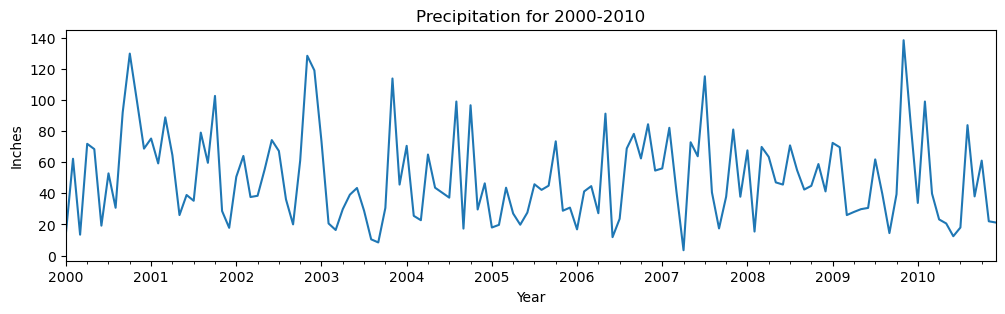

In [18]:
# Plot the feature and time period
fig, ax = plt.subplots(figsize=(12, 3))
precipitation_monthly.plot(ax=ax, title="Precipitation for 2000-2010", ylabel="Inches")
ax.set_xlabel("Year")
ax.set_ylabel("Inches")


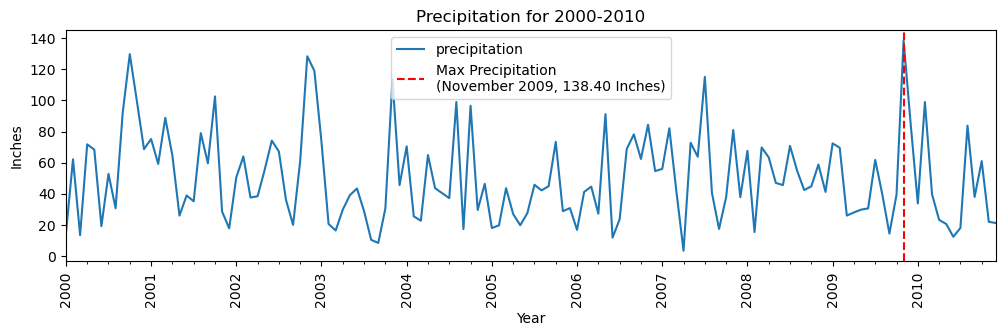

In [38]:
# Plot the feature and time period
fig, ax = plt.subplots(figsize=(12, 3))
precipitation_monthly.plot(ax=ax, title="Precipitation for 2000-2010", ylabel="Inches")
ax.set_xlabel("Year")
ax.set_ylabel("Inches")



plt.xticks(rotation=90)


# Customize the minor xaxis ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(3))  # Minor ticks every 3 months
ax.xaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: ''))  # No labels for minor ticks

# Add a vertical line at the date of max precipitation
ax.axvline(x=max_precipitation_date, color='red', linestyle='--', label=f'Max Precipitation\n({max_precipitation_date.strftime("%B %Y")}, {max_precipitation_value:.2f} Inches)')
ax.legend()


# Show the plot

plt.show()

## Q2: Which year between 2000-2020 had the coolest average temperature?

In [22]:
# Create a new copy of the dataframe for this question
df_q2 = df['2000-01-01':'2020-12-31'].copy()


In [24]:
# Resample the mean_temp data to a Yearly frequency using .mean() as the aggregation method
mean_temp_yearly = df_q2['mean_temp'].resample('Y').mean()
mean_temp_yearly

date
2000-12-31    11.575683
2001-12-31    11.331507
2002-12-31    12.084247
2003-12-31    12.114521
2004-12-31    11.900683
2005-12-31    11.822877
2006-12-31    12.290822
2007-12-31    11.944384
2008-12-31    11.326776
2009-12-31    11.721644
2010-12-31    10.657397
2011-12-31    12.366438
2012-12-31    11.300956
2013-12-31    11.166301
2014-12-31    12.658904
2015-12-31    12.123699
2016-12-31    11.906284
2017-12-31    12.242466
2018-12-31    12.501370
2019-12-31    12.206164
2020-12-31    12.723634
Freq: A-DEC, Name: mean_temp, dtype: float64

In [26]:
# Determine the date and value for the lowest mean temp
lowest_mean_temp_value = mean_temp_yearly.min()
lowest_mean_temp_value

10.657397260273973

In [28]:
lowest_mean_temp_date = mean_temp_yearly.idxmin()
lowest_mean_temp_date

Timestamp('2010-12-31 00:00:00', freq='A-DEC')

Text(0, 0.5, 'Degrees')

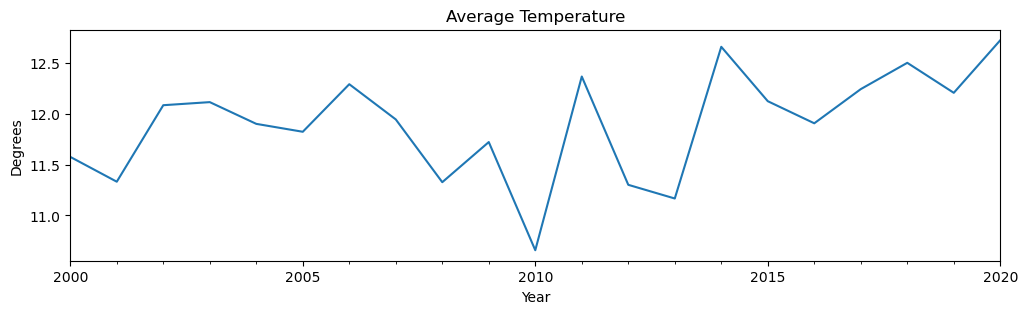

In [35]:

# Plot the feature and time period
fig, ax = plt.subplots(figsize=(12, 3))
mean_temp_yearly.plot(ax=ax, title="Average Temperature", ylabel="Degrees")
ax.set_xlabel("Year")
ax.set_ylabel("Degrees")

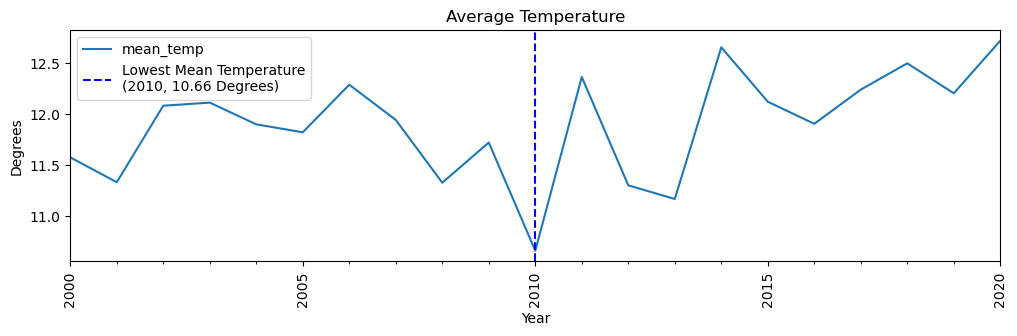

In [37]:


# Plot the feature and time period
fig, ax = plt.subplots(figsize=(12, 3))
mean_temp_yearly.plot(ax=ax, title="Average Temperature", ylabel="Degrees")
ax.set_xlabel("Year")
ax.set_ylabel("Degrees")


plt.xticks(rotation=90)

# Customize the minor xaxis ticks
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))  # Minor ticks every 1 year
ax.xaxis.set_minor_formatter(plt.FuncFormatter(lambda x, _: ''))  # No labels for minor ticks

# Add a vertical line at the date of lowest mean temperature
ax.axvline(x=lowest_mean_temp_date, color='blue', linestyle='--', label=f'Lowest Mean Temperature\n({lowest_mean_temp_date.strftime("%Y")}, {lowest_mean_temp_value:.2f} Degrees)')
ax.legend()

# Show the plot

plt.show()